In [1]:
import os
data_dir = 'cell_images'
os.listdir(data_dir)

['test', 'train']

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib.image import imread

In [4]:
test_path = data_dir + '\\test\\'
train_path = data_dir + '\\train\\'

In [6]:
test_path

'cell_images\\test\\'

In [7]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [8]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [10]:
os.listdir(train_path+os.listdir(train_path)[0])[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [11]:
para_cell = train_path+'parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_cell

'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

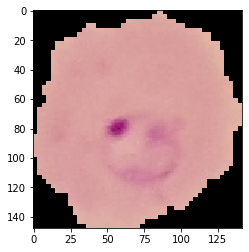

In [14]:
plt.imshow(imread(para_cell))

In [16]:
os.listdir(train_path+'uninfected')[0]

'C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [17]:
uninfected_cell = train_path+'uninfected\\'+'C100P61ThinF_IMG_20150918_144104_cell_128.png'
uninfected_cell

'cell_images\\train\\uninfected\\C100P61ThinF_IMG_20150918_144104_cell_128.png'

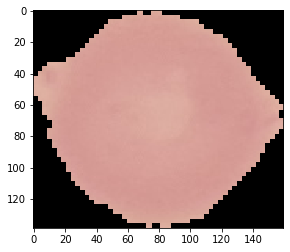

In [19]:
plt.imshow(imread(uninfected_cell))

In [23]:
len(os.listdir(test_path+'parasitized'))

1300

In [24]:
len(os.listdir(test_path+'uninfected'))

1300

In [25]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'uninfected'):
    img = imread(test_path+'uninfected\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

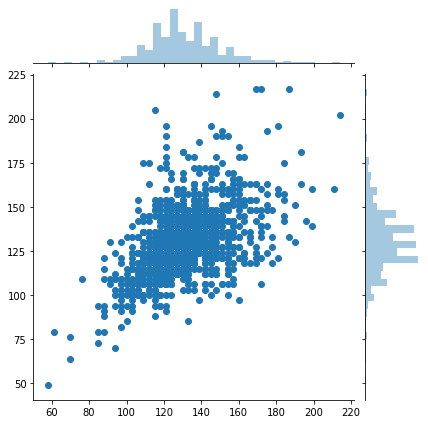

In [27]:
sns.jointplot(dim1,dim2)

In [28]:
np.mean(dim1)

130.92538461538462

In [29]:
np.mean(dim2)

130.75

In [30]:
image_shape = (130,130,3)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range = 0.1,
                              shear_range = 0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

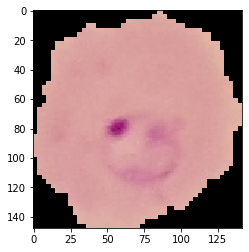

In [39]:
para_img = imread(para_cell)
plt.imshow(para_img)

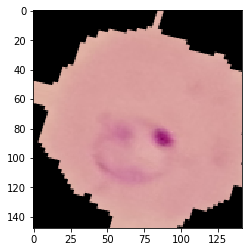

In [43]:
plt.imshow(image_gen.random_transform(para_img))
# para_img

In [44]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [45]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten

In [50]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_los',patience=2)

In [54]:
batch_size = 16
train_image_gen = image_gen.flow_from_directory(train_path,target_size=image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')
test_image_gen =  image_gen.flow_from_directory(test_path,target_size=image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [55]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [59]:
# results = model.fit_generator(train_image_gen,
#                              epochs = 20,
#                              validation_data=test_image_gen,
#                              callbacks=[early_stop])
from tensorflow.keras.models import load_model
model = load_model('malaria_detector.h5')

In [61]:
model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[36.2022705078125, 0.8700000047683716]

In [62]:
model.metrics_names

['loss', 'accuracy']

In [63]:
pred = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [64]:
pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [71]:
predictions = pred > 0.7

In [72]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [73]:
len(pred)

2600

In [74]:
from sklearn.metrics import classification_report,confusion_matrix
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [75]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1300
           1       0.98      0.76      0.85      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



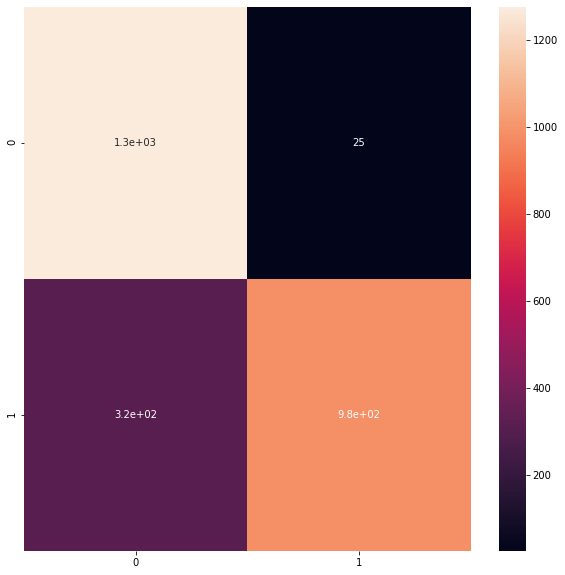

In [88]:
confusion_matrix(test_image_gen.classes,predictions)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(test_image_gen.classes,predictions),annot=True)

In [79]:
from tensorflow.keras.preprocessing import image
my_image = image.load_img(para_cell,target_size=image_shape)

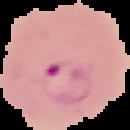

In [80]:
my_image

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [84]:
img_array = image.img_to_array(my_image)
img_array.shape

(130, 130, 3)

In [86]:
img_array = np.expand_dims(img_array,axis=0)
model.predict(img_array)

array([[0.]], dtype=float32)